In [51]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi, sin, cos

## Exploring Qubits with qiskit
We start a quantum circuit, which starts with the statevector |0> by default. The initialize() method transforms this into any state.

In [19]:
qc = QuantumCircuit(1)
initial_state = [0, 1]
qc.initialize(initial_state, 0) # initialisation operation applied to the 0th qubit
sim = Aer.get_backend("aer_simulator")
qc.save_statevector() # state vector saved by the system
qobj = assemble(qc) # quantum object from the quantum circuit
result = sim.run(qobj).result() # running the simulation and returning the result
out_state = result.get_statevector() # printing the state vector
print(out_state)

Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


Measuring now as a quantum computer would.

In [20]:
qc.measure_all()
qc.draw()

┌─────────────────┐ ░  ░ ┌─┐
     q: ┤ Initialize(0,1) ├─░──░─┤M├
        └─────────────────┘ ░  ░ └╥┘
meas: 1/══════════════════════════╩═
                                  0

Getting the counts and plotting a histogram with our results. We observe the probability to be 1, given the lack of any quantum interactions currently.

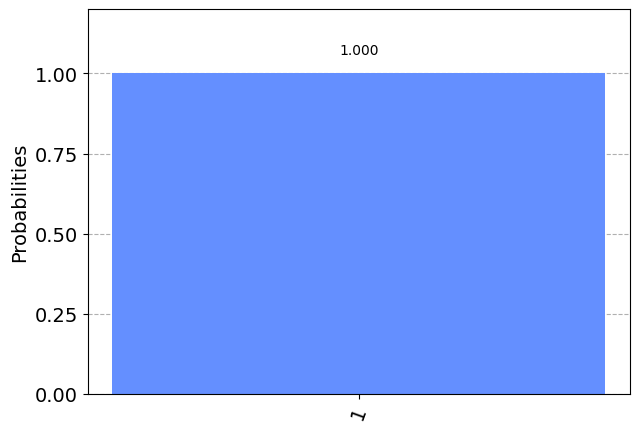

In [21]:
counts = result.get_counts()
plot_histogram(counts)

Now, let's try and put our qubit into a superposition.

In [22]:
initial_state = [1/sqrt(2), 1j/sqrt(2)]
qc = QuantumCircuit(1)
qc.initialize(initial_state, 0)
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
print(state)

Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


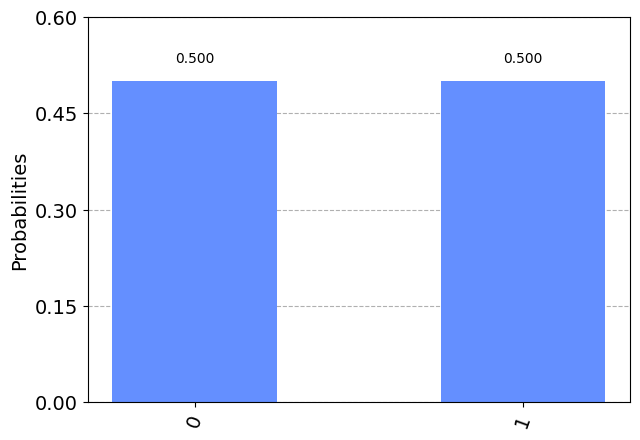

In [23]:
results = sim.run(qobj).result().get_counts()
plot_histogram(results)

We see an equal probability of measuring each state, since the statevector of this qubit was the sum of two other qubits.

## The Rules of Measurement
The formula for finding the probability of state $\ket{\psi}$ is measured as $\ket{x}$ is: 
$$
p(\ket{x}) = |{\braket{\psi|x}}|^2
$$
$\bra{x}$ (bra notation) is a row vector, whereas $\ket{\psi}$ (ket notation) is a column vector. Each ket has a corresponding bra, and both are converted between each other using conjugate transpose (quite simply, an input matrix is transposed with the elements complex conjugated). 


### Implications
#### Normalisation
Probabilities will not add up to 1 if the statevector is not properly normalized (magnitude equal to 1).
$$\braket{\psi | \psi} = 1$$
If:
$$\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$$
Then:
$$|\alpha|^2 + |\beta|^2 = 1$$

#### Alternative measurement
$\ket{x}$ is not limited to only being $\ket{0}$ or $\ket{1}$, there are actually infinite ways to measure qubits from any orthogonormal pair of states.

#### Global phase
We can see that state $\ket{1}$ gives an output of 1 with certainty, but there are also states like
$$\begin{bmatrix}0\\i\end{bmatrix} = i\ket{1}$$
If we apply the measurement rule to this, we get
$$ |{\braket{x|(i|1)}}|^2 = |i{\braket{x|1}}|^2 = |{\braket{x|1}}|^2 $$
Since the factor $i$ disappears when the magnitude of the complex number is taken, we observe that the states $i\ket{1}$ and $\ket{1}$ are equal. An factor $\zeta$ on a state where $|\zeta| = 1$ is a 'global phase'. We can generally state that
$$ |{\braket{x|(\zeta|1)}}|^2 = |\zeta{\braket{x|1}}|^2 = |{\braket{x|1}}|^2 $$


##### The Observer Effect
Once a qubit has been measured, it can be said with certainty what state the qubit is in-- measuring qubits changes their state. In quantum mechanics, this reduction from multiple states to one is referred to as a 'collapse'. Therefore, if measured constantly, qubits would assume clearly defined states of $\ket{0}$ or $\ket{1}$, which is no different from how a classical computer operates. Quantum computation lies on allowing qubits to assume complex states and carrying out measurements only when an output is required (at the end of a quantum circuit). This phenonmenon can be easily represented by a quantum circuit.

In [24]:
qc = QuantumCircuit(1)
initial_state = [0. + 1.j/sqrt(2), 1/sqrt(2) + 0.j]
qc.initialize(initial_state, 0)
qc.draw()

┌──────────────────────────────┐
q: ┤ Initialize(0.70711j,0.70711) ├
   └──────────────────────────────┘

Above, a qubit with state 
$$ \ket{q} = \frac{i}{\sqrt{2}} \ket{0} + \frac{1}{\sqrt{2}} \ket{1}$$
is initialised.

In [25]:
qc.save_statevector()
result = sim.run(assemble(qc)).result()
print("State: {}".format(result.get_statevector()))


State: Statevector([0.        +0.70710678j, 0.70710678+0.j        ],
            dims=(2,))


We get the state as expected from initialising the qubit earlier. Below, we create a circuit where we measure the qubit.

In [32]:
qc = QuantumCircuit(1)
qc.initialize(initial_state, 0)
qc.measure_all()
qc.save_statevector()
qc.draw()

┌──────────────────────────────┐ ░ ┌─┐ ░ 
     q: ┤ Initialize(0.70711j,0.70711) ├─░─┤M├─░─
        └──────────────────────────────┘ ░ └╥┘ ░ 
meas: 1/════════════════════════════════════╩════
                                            0

In [43]:
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
print("Measured state: {}".format(state))

Measured state: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


When we run the above cell, we notice that there is an equal probability of measuring each state, and there is never a superposition of $\ket{0}$ and $\ket{1}$ since the state collapses upon measurement. One of the amplitudes is always 0. Usage of .save_statevector() and .get_statevector() at various points is recommmended instead of measuring (courtesy of the aer_simulator).

### The Bloch Sphere
#### Describing the Restricted Qubit State
Given that global phase cannot be measured and that only the difference in phase between $\ket{0}$ and $\ket{1}$ can be measured, the state should be represented as
$$ \ket{q} = \alpha \ket{0} + e^{i\phi} \beta \ket{1} $$
which confines $\alpha$ and $\beta$ to be real numbers. From using the fact that the qubit state must be normalised, $\alpha$ and $\beta$ can be written as
$$ \alpha = \cos{\frac{\theta}{2}}, $$
$$ \beta = \sin{\frac{\theta}{2}} $$
which can be used to describe the state of any qubit:
$$ \ket{q} = \cos{\frac{\theta}{2}} \ket{0} + e^{i\phi} \sin{\frac{\theta}{2}} \ket{1} $$

#### Visual Representation
The Bloch sphere is a sphere whose surface contains any single qubit state. By using the state defined above and interpreting the $\theta$ and $\phi$ as spherical coordinates, this provides the basis for the Bloch sphere. Qiskit includes a function plot_bloch_vector() to visualise this. Bear in mind that this function takes cartesian coordinates as an input, so conversion to spherical coordinates is required for visualising our state $\ket{q}$. I wrote a simple conversion function below.

In [49]:
from array import array


def sphericalToCartesian(r, theta, phi):
    """
    Converts spherical coordinates to cartesian.

    Args:
        r: radius of the sphere
        theta: angle made with the z-axis
        phi: angle made with the x-axis

    Returns: 
        array: An array of size 3 with each element corresponding to cartesian coordinates

    """
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)
    return [x, y, z]
    

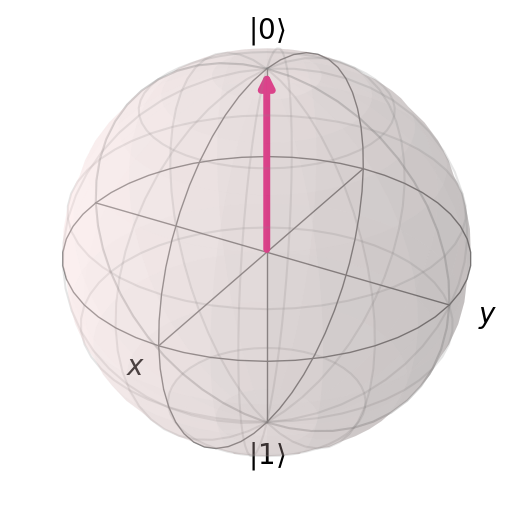

In [52]:
plot_bloch_vector(sphericalToCartesian(1, 0, pi/2))